In [ ]:
# Attempt to improve the DMFT code

import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
########################################################################
# INPUTS
########################################################################

D0, u0, nloop, xmix, n_omega, beta, tol, seed, ctnpath, wannasave, savepath  = 1.0, 1.5, 500, 0.5, 2000, 100, 1e-8, 0, "", False, ""

# 0 is the metallic seed; 1 is the insulating seed

try:

    data1 = np.loadtxt('.\\DOS.txt')
    energies = data1[:,0]
    DOS   = data1[:,1]

except:

    energies = np.linspace(-D0, D0, 1000)
    DOS = 2*np.sqrt(1-(energies/D0)**2)/(np.pi * D0)

In [15]:
########################################################################
# DMFT ROUTINES
########################################################################

# Computation of the local Green's function

def Dyson_Green (S_imp, energies, dos, Momega):

    """
    From the self-energy in Matsubara axis, computes the local Green's
    function of the system, as an integral over energies.

    Input:
        S_imp: The current impurity self-energy in Matsubara axis
        Energies: The energy grid used to obtain the local Green's function
        dos: The input DOS of the system, evaluated in Energies
        Momega: Matsubara frequencies grid


    Output:
        G_loc: Local Green's function in Matsubara axis

    """
    
    from scipy.integrate import simpson
    denergies_bethe = energies[2] - energies[1]
    return simpson( dos/(1j*Momega[:,np.newaxis]-energies-S_imp[:,np.newaxis]), dx=denergies_bethe)

In [16]:
# IPT solver; computes the new self-energy

def Self_Energy_fromG (g0, U, tau, Momega):

    """
    IPT solver to obtain the new self-energy in Matsubara axis from the
    Weiss mean field in imaginary time axis.

    Input:
        g0: Weiss mean field in imaginary time axis
        U: Hubbard interaction parameter
        tau: Imaginary time grid
        Momega: Matsubara frequencies grid


    Output:
        new_S_imp: Updated self-energy in the Matsubara axis

    """

    dtau = tau[1] - tau[0]
    esp = np.exp(1.0j*np.tensordot(tau, Momega, 0))
    g0_minus = -np.roll(g0[::-1],1)
    g0_minus[0] = -g0_minus[0]
    integrand = g0*g0*g0_minus
    new_S_imp = -U*U*dtau*np.matmul(integrand,esp)
    
    return new_S_imp

In [17]:
# Fast inverse Fourier transform

def matsubara_ifft(G_omega, beta, Momega):

    """
    Fast inverse Fourier transform. Computes the function in imaginary 
    time axis. It's assumed that both time and frequency axis have the
    same length.

    Input:
        G_omega: Function in Matsubara axis
        beta: Inverse temperature of the system
        Momega: Matsubara frequencies grid


    Output:
        G_loc: Local Green's function in Matsubara axis

    """

    
    N = len(Momega)
#    freq = np.pi/beta*( np.array(-2*N*np.fft.fftfreq(N),dtype=float) +1.)
    k = np.arange(N,dtype='float')
    ifft = -1./2 + N/beta * np.exp(-1.0j*np.pi*k/N) * np.fft.ifft(G_omega - 1./(1.0j*Momega))
    
    return ifft

In [18]:
# Main DMFT loop: first iteration and subsequent iterations

def DMFT_first_iteration(u0, S_imp, Energies, dos, Momega, tau, beta):

    """
    First iteration of the DMFT loop. Returns the updated self-energy,  
    as well as the non-interacting Green's function and the impurity 
    Green's function.

    Input:
        u0: The Hubbard interaction parameter
        S_imp: The current impurity self-energy in Matsubara axis
        Energies: The energy grid used to obtain the local Green's function
        dos: The input DOS of the system, evaluated in Energies
        Momega: Matsubara frequencies grid
        tau: Imaginary time grid
        beta: Inverse temperature of the system


    Output:
        G_loc: Local Green's function in Matsubara axis
        g_0: Weiss mean field in Matsubara axis
        g_0_tau: Weiss mean field in imaginary time axis
        new_S_imp: Updated self-energy in Matsubara axis, from IPT solver 

    """
    
    G_loc = Dyson_Green(S_imp, Energies, dos, Momega)    # Local GF in Matsubaras
  
    g_0 = G_loc/(1+G_loc*S_imp)                          # Weiss MF from Dyson equation
    g_0_tau = matsubara_ifft(g_0, beta, Momega)          # Weiss MF in imaginary time axis

    # Sanity check of the Weiss MF in the first iteration
    fig, ax = plt.subplots(1, 1, figsize = (8,6))
    ax.plot(tau, g_0_tau.real, 'k-')
    ax.set_title('First iteration', fontsize = 16)
    ax.set_xlabel(r'$\tau$', fontsize = 14)
    ax.set_ylabel(r'$\text{Re} \; G_0 (\tau)$', fontsize = 14)
    plt.show()


    new_S_imp = Self_Energy_fromG(g_0_tau, u0, tau, Momega) # Updated self-energy 

    return G_loc, g_0, g_0_tau, new_S_imp


def DMFT_iteration(u0,S_imp,Energies,dos,Momega,tau,beta):

    """
    Iteration of the DMFT loop. Returns the updated self-energy,  
    as well as the non-interacting Green's function and the impurity 
    Green's function.

    Input:
        u0: The Hubbard interaction parameter
        S_imp: The current impurity self-energy in Matsubara axis
        Energies: The energy grid used to obtain the local Green's function
        dos: The input DOS of the system, evaluated in Energies
        Momega: Matsubara frequencies grid
        tau: Imaginary time grid
        beta: Inverse temperature of the system


    Output:
        G_loc: Local Green's function in Matsubara axis
        g_0: Weiss mean field in Matsubara axis
        g_0_tau: Weiss mean field in imaginary time axis
        new_S_imp: Updated self-energy in Matsubara axis, from IPT solver 

    """
    
    G_loc = Dyson_Green(S_imp, Energies, dos, Momega)    # Local GF in Matsubaras
    g_0 = G_loc/(1+G_loc*S_imp)                          # Weiss MF from Dyson equation
    g_0_tau = matsubara_ifft(g_0, beta, Momega)  # Weiss MF in imaginary time axis

    new_S_imp = Self_Energy_fromG(g_0_tau,u0,tau,Momega) # Updated self-energy  

    return G_loc, g_0, g_0_tau, new_S_imp

In [19]:
# Dyson equation

def solve_dyson(G_0, sigma):
    
    """
    Solves the Dyson equation given the impurity self-energy and a non-interacting Green's function. 
    
    Yields the impurity Green's function

    Input:
        G_0:   Non-interacting Green's function in Matsubara axis
             
        Sigma: The impurity self-energy
        
    Output:
        G_imp: Impurity Green's function in Matsubara axis 
    """
    
    inverse_G0 = 1/G_0
    G_imp = 1/(inverse_G0 - sigma)
    
    return G_imp

In [20]:
# Self consistent test

def convergence_test(G_imp, G_loc, tol):
    
    """
    Given the newly computed impurity Green's function and the old local Green's
    function, performs the convergence test.
    
    Returns True if convergence has been reached with precision delta. Returns 
    False otherwise.
    
    Input:
        G_imp: New impurity Green's function in Matsubara axis
        G_loc: Old local Green's function in Matsubara axis
        delta: Precision level of the DMFT loop
        
    Output:
        bool: True if convergence has been achieved; false otherwise
    """

    difference = np.absolute(G_imp - G_loc)**2
    D = np.sqrt(np.sum(difference))
    
    return (bool(np.where(D < tol, True, False)), D)

In [21]:
# Spectral function

def pade_analytic_cont(G_loc, Momega, n_freqs):
    
    '''
    Given the local Green's function in the Matsubara axis, computes the analytical
    continuation to the real axis with the Maximum Entropy method.
    
    Input:
        G_loc:  Local Green's function in Matsubara axis
        Momega: Matsubara frequency axis grid
        n_freqs: number of Matsubara frequencies to be used in the Padé approximant
        
    Output:
        Romega: Real frequency axis grid
        spectral: Spectral function in the real axis
    '''
    path = '.\\g_loc'
    with open(path, 'w') as writer:

        for i in range(n_freqs):
            writer.write(str(Momega[Momega>0][i]) + ' ' + str(np.real(G_loc[Momega>0][i])) + ' ' + str(np.imag(G_loc[Momega>0][i])) +'\n')

    import os
    os.system('.\\Pade\\pade.exe -if=g_loc -inener=imag -emin=-4.0 -emax=4.0 -eta=0.01 -npoints=100')

    data = np.loadtxt('.\\g_loc__output')
    Romega = data[:,0]
    spectral = -data[:,3]/np.pi

    return Romega, spectral

In [ ]:
########################################################################
# INITIALIZE FUNCTIONS
########################################################################

#Momega = (2*np.arange(n_omega) + 1)*np.pi/beta
Momega = np.pi/beta*( np.array(-2*n_omega*np.fft.fftfreq(n_omega),dtype=float) +1.)
tau = np.linspace(0, beta*(1. - 1./n_omega), n_omega)
if len(ctnpath)>0:
    try:
        with open(ctnpath,'r') as f:
            f.read(ctnpath)
            f.close()
    except:
        pass
if seed == 0:
    S_imp = np.zeros((len(Momega)), dtype=complex)
else:
    S_imp = 1/(1j * Momega)

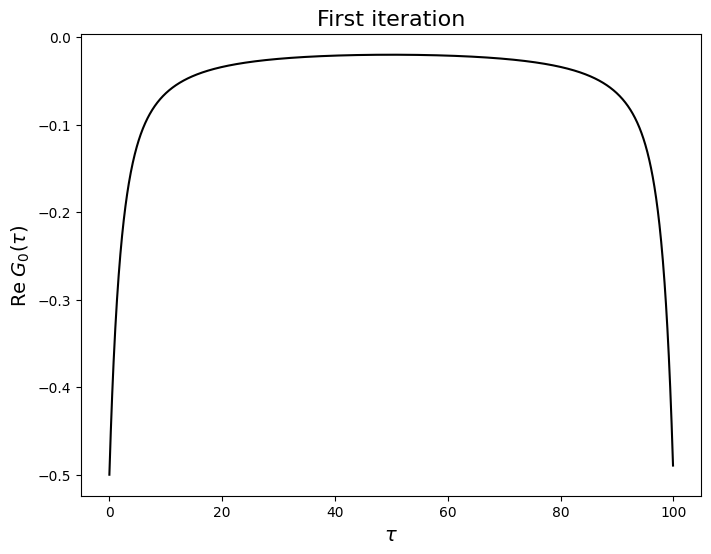

ITERATION 5
Convergence test: 0.019992212652962246
 
ITERATION 10
Convergence test: 0.001344304990679576
 
ITERATION 15
Convergence test: 9.204627830349178e-05
 
ITERATION 20
Convergence test: 6.460334013657231e-06
 
ITERATION 25
Convergence test: 4.695990381783789e-07
 
ITERATION 30
Convergence test: 3.5642814127514554e-08
 
 
Convergence has been reached, iteration 32


In [ ]:
########################################################################
# DMFT LOOP
########################################################################

G_loc, g_0, g_0_tau, new_S_imp = DMFT_first_iteration(u0, S_imp, energies, DOS, Momega, tau, beta)
G_imp = solve_dyson(g_0, new_S_imp)
S_imp = new_S_imp
converged_flag = False

for k_loop in range(nloop):

    G_loc, g_0, g_0_tau, new_S_imp = DMFT_iteration(u0, S_imp, energies, DOS, Momega, tau, beta)
    G_imp = solve_dyson(g_0, new_S_imp)
    if wannasave:
        if os.path.exists(savepath):
            os.remove(savepath)
        with open(savepath, 'w') as f:
            f.write(new_S_imp)
            f.close()
    
    if convergence_test(G_imp, G_loc, tol)[0]:
        print(' ')
        print('Convergence has been reached, iteration '+str(k_loop))
        converged_flag = True
        break
    else:
        S_imp = xmix * new_S_imp + (1-xmix) * S_imp
        
        if (k_loop + 1)%5 == 0:
            print(f'ITERATION {k_loop + 1}')
            print(f'Convergence test: {convergence_test(G_imp, G_loc, tol)[1]}')
            print(' ')

if not converged_flag:
    print('WARNING: Completed the required number of iterations without reaching convergence')

G_tau = matsubara_ifft(G_loc, beta, Momega)
Momega = np.fft.fftshift(Momega)[::-1]
G_loc  = np.fft.fftshift(G_loc)[::-1]
S_imp  = np.fft.fftshift(S_imp)[::-1]

path1 = '.\\g_loc.dat'
with open(path1, 'w') as writer:

    for i in range(n_omega//2):
        writer.write(str(Momega[Momega>0][i]) + ' ' + str(np.real(G_loc[Momega>0][i])) + ' ' + str(np.imag(G_loc[Momega>0][i])) +'\n')

path2 = '.\\sigma.dat'
with open(path2, 'w') as writer:

    for i in range(n_omega//2):
        writer.write(str(Momega[Momega>0][i]) + ' ' + str(np.real(S_imp[Momega>0][i])) + ' ' + str(np.imag(S_imp[Momega>0][i])) +'\n')

path3 = '.\\g_tau.dat'
with open(path3, 'w') as writer:

    for i in range(len(tau)):
        writer.write(str(tau[i]) + ' ' + str(np.real(G_tau[i])) + ' ' + str(np.imag(G_tau[i])) +'\n')

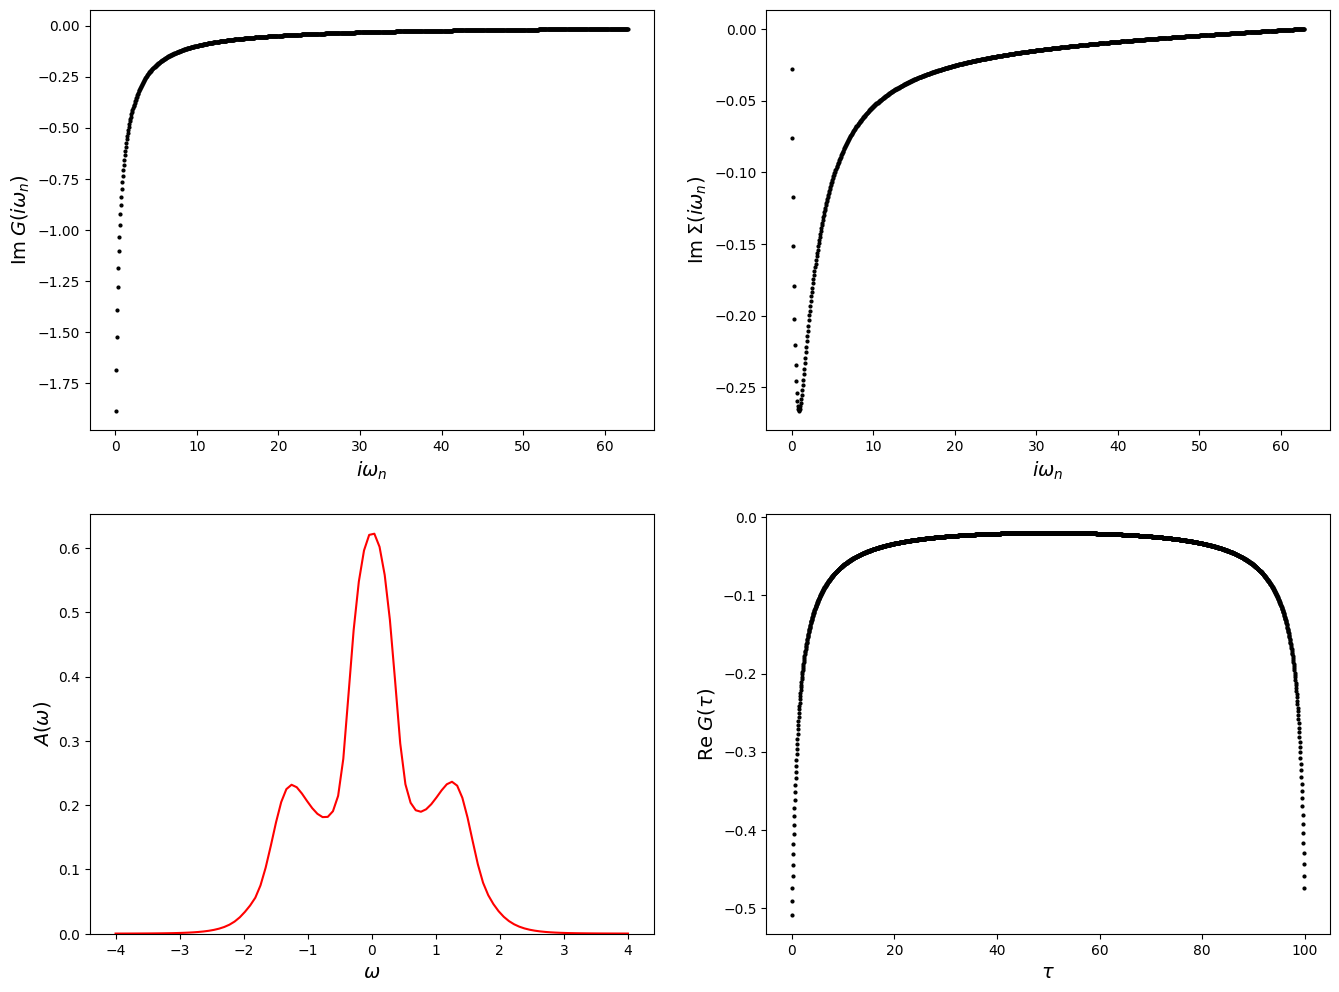

In [24]:
Romega, spectral = pade_analytic_cont(G_loc, Momega, 200)

fig, ax = plt.subplots(2,2,figsize=(16,12))

ax[0,0].plot(Momega[Momega>0][:], G_loc.imag[Momega>0][:], 'ko', ms = 2)
ax[0,0].set_xlabel(r'$i\omega_n$', fontsize = 14)
ax[0,0].set_ylabel(r'$\text{Im} \; G(i\omega_n)$', fontsize = 14)

ax[0,1].plot(Momega[Momega>0][:], S_imp.imag[Momega>0][:], 'ko', ms = 2)
ax[0,1].set_xlabel(r'$i\omega_n$', fontsize = 14)
ax[0,1].set_ylabel(r'$\text{Im} \; \Sigma(i\omega_n)$', fontsize = 14)

ax[1,0].plot(Romega, spectral, 'r-')
ax[1,0].set_ylim(0)
ax[1,0].set_xlabel(r'$\omega$', fontsize = 14)
ax[1,0].set_ylabel(r'$A(\omega)$', fontsize = 14)

ax[1,1].plot(tau, G_tau.real, 'ko', ms = 2)
ax[1,1].set_xlabel(r'$\tau$', fontsize = 14)
ax[1,1].set_ylabel(r'$\text{Re} \; G(\tau)$', fontsize = 14)

plt.show()